##### Import 

In [69]:
source("import.R")

# STEP1: INCLUDE CONTROL METRICS

In [70]:
m1 <- glm(post ~ CC_max + PAR_max + FOUT_max, data = data, family="binomial")
anova(m1)

,Df,Deviance,Resid. Df,Resid. Dev
,<int>,<dbl>,<int>,<dbl>
NULL,NA,NA,6728,5568.263
CC_max,1,600.97611,6727,4967.287
PAR_max,1,131.45283,6726,4835.835
FOUT_max,1,60.20786,6725,4775.627


In [71]:
m2 <- glm(post ~ TLOC + CC_max + PAR_max + FOUT_max, data = data, family="binomial")
anova(m2)

,Df,Deviance,Resid. Df,Resid. Dev
,<int>,<dbl>,<int>,<dbl>
NULL,NA,NA,6728,5568.263
TLOC,1,709.19340,6727,4859.070
CC_max,1,74.55689,6726,4784.513
PAR_max,1,63.35217,6725,4721.161
FOUT_max,1,17.40582,6724,4703.755


In [72]:
importance <- data.frame(m1=c(0,anova(m1)$Deviance[-1]), m2=anova(m2)$Deviance[-1])
importance <- data.frame(apply(importance, 2, function(x){x/sum(abs(x))}))
rownames(importance) <- c("TLOC","CC_max","PAR_max","FOUT_max")
round(importance,digit=2)*100

,m1,m2
,<dbl>,<dbl>
TLOC,0,82
CC_max,76,9
PAR_max,17,7
FOUT_max,8,2


# STEP2: REMOVE CORRELATED METRICS

## THE RISKS OF NOT REMOVING CORRELATED METRICS

In [73]:
m1 <- glm(post ~ CC_max + + CC_avg + PAR_max + FOUT_max, data = data, family="binomial")
anova(m1)

,Df,Deviance,Resid. Df,Resid. Dev
,<int>,<dbl>,<int>,<dbl>
NULL,NA,NA,6728,5568.263
CC_max,1,600.97611,6727,4967.287
CC_avg,1,18.67344,6726,4948.614
PAR_max,1,129.71197,6725,4818.902
FOUT_max,1,57.87581,6724,4761.026


In [74]:
m2 <- glm(post ~ CC_avg + CC_max + PAR_max + FOUT_max, data = data, family="binomial")
anova(m2)

,Df,Deviance,Resid. Df,Resid. Dev
,<int>,<dbl>,<int>,<dbl>
NULL,NA,NA,6728,5568.263
CC_avg,1,467.41722,6727,5100.846
CC_max,1,152.23233,6726,4948.614
PAR_max,1,129.71197,6725,4818.902
FOUT_max,1,57.87581,6724,4761.026


In [75]:
importance <- data.frame(m1=anova(m1)$Deviance[-1], m2=anova(m2)$Deviance[c(3,2,4,5)])
importance <- data.frame(apply(importance, 2, function(x){x/sum(abs(x))}))
rownames(importance) <- c("CC_max","CC_avg","PAR_max","FOUT_max")
round(importance,digit=2)*100

,m1,m2
,<dbl>,<dbl>
CC_max,74,19
CC_avg,2,58
PAR_max,16,16
FOUT_max,7,7


## SPEARMAN'S CORRELATION ANALYSIS

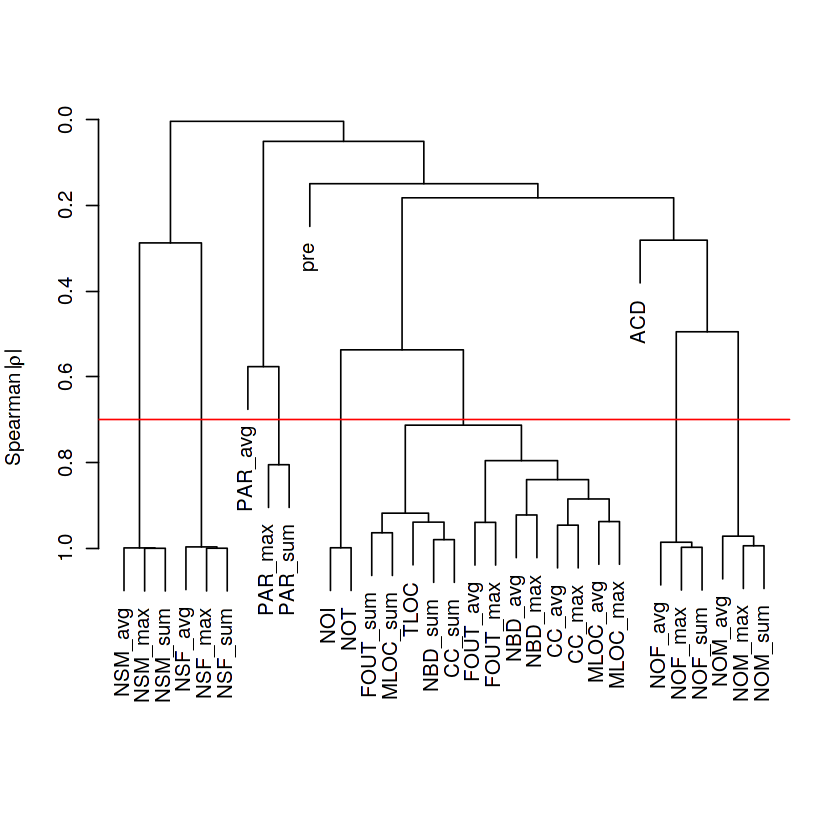

In [76]:
indep <- eclipse$indep
plot(varclus(as.matrix(data[,indep]), similarity="spear", trans="abs"))
abline(h=0.3, col="red")

## AutoSpearman: AUTOMATICALLY REMOVE CORRELATED METRICS

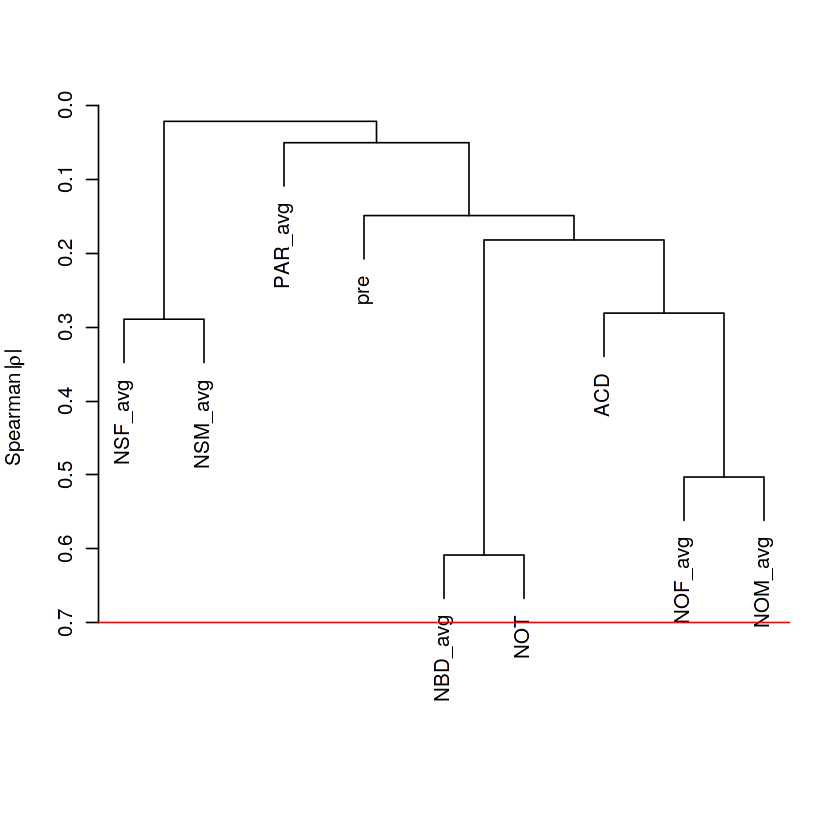

In [77]:
library(Rnalytica)
filterindep <- AutoSpearman(data, indep)
plot(varclus(as.matrix(data[, filterindep]), similarity="spear", trans="abs"))
abline(h=0.3, col="red")

# STEP3: BUILD EXPLAINABLE MODELS

In [78]:
indep <- AutoSpearman(data, eclipse$indep)

## A Decision Tree Model

In [79]:
tree.model <- C5.0(x = data[,indep], y = data[,dep])
summary(tree.model)


Call:
C5.0.default(x = data[, indep], y = data[, dep])


C5.0 [Release 2.07 GPL Edition]  	Wed May  8 01:47:48 2019
-------------------------------

Class specified by attribute `outcome'

Read 6729 cases (10 attributes) from undefined.data

Decision tree:

pre <= 1:
:...NOM_avg <= 17.5: FALSE (4924/342)
:   NOM_avg > 17.5:
:   :...NBD_avg > 1.971831:
:       :...ACD <= 2: TRUE (51/14)
:       :   ACD > 2: FALSE (5)
:       NBD_avg <= 1.971831:
:       :...NBD_avg <= 1.029412: FALSE (64/2)
:           NBD_avg > 1.029412:
:           :...NOM_avg <= 64: FALSE (332/77)
:               NOM_avg > 64: TRUE (21/7)
pre > 1:
:...pre > 6:
    :...pre > 12: TRUE (77/13)
    :   pre <= 12:
    :   :...NSM_avg > 0.25: TRUE (56/17)
    :       NSM_avg <= 0.25:
    :       :...NOF_avg <= 10.5: FALSE (94/39)
    :           NOF_avg > 10.5: TRUE (11/2)
    pre <= 6:
    :...NBD_avg <= 1.012195: FALSE (180/19)
        NBD_avg > 1.012195:
        :...NOM_avg > 23.5:
            :...ACD <= 0:
           

## Plot

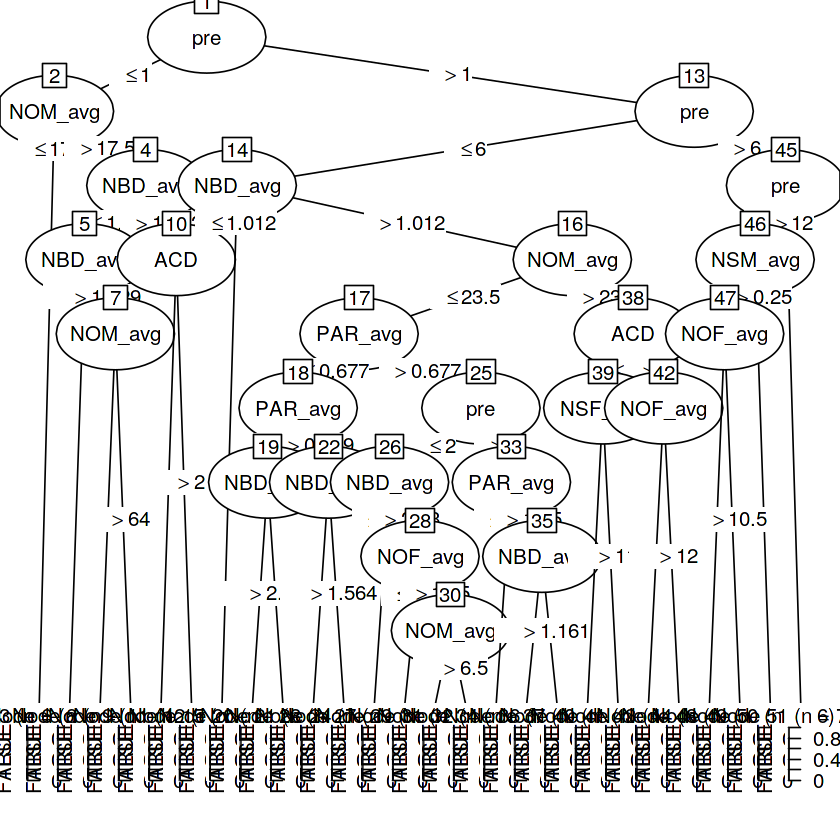

In [80]:
plot(tree.model)

## Build a Rule-Based Model

In [81]:
rule.model <- C5.0(x = data[, indep], y = data[,dep], rules = TRUE)

## Print a model summary

In [82]:
summary(rule.model)


Call:
C5.0.default(x = data[, indep], y = data[, dep], rules = TRUE)


C5.0 [Release 2.07 GPL Edition]  	Wed May  8 01:47:49 2019
-------------------------------

Class specified by attribute `outcome'

Read 6729 cases (10 attributes) from undefined.data

Rules:

Rule 1: (2910/133, lift 1.1)
	pre <= 6
	NBD_avg <= 1.16129
	->  class FALSE  [0.954]

Rule 2: (3680/217, lift 1.1)
	pre <= 2
	NOM_avg <= 6.5
	->  class FALSE  [0.941]

Rule 3: (4676/316, lift 1.1)
	pre <= 1
	NBD_avg <= 1.971831
	NOM_avg <= 64
	->  class FALSE  [0.932]

Rule 4: (4924/342, lift 1.1)
	pre <= 1
	NOM_avg <= 17.5
	->  class FALSE  [0.930]

Rule 5: (5423/547, lift 1.1)
	pre <= 6
	NOM_avg <= 23.5
	PAR_avg <= 1.75
	->  class FALSE  [0.899]

Rule 6: (5189/552, lift 1.0)
	pre <= 12
	NOF_avg <= 10.5
	NSM_avg <= 0.25
	->  class FALSE  [0.893]

Rule 7: (77/13, lift 5.7)
	pre > 12
	->  class TRUE  [0.823]

Rule 8: (54/11, lift 5.4)
	NBD_avg > 1.029412
	NOM_avg > 64
	->  class TRUE  [0.786]

Rule 9: (11/2, lift 5.3)
	pre > 6

## Build a Random Forest model

In [83]:
f <- as.formula(paste( "post", '~', paste(indep, collapse = "+")))
rf.model <- randomForest(f, data = data, importance = TRUE, keep.forest=TRUE)

## Print a Random Forest model

In [84]:
print(rf.model)


Call:
 randomForest(formula = f, data = data, importance = TRUE, keep.forest = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 12.71%
Confusion matrix:
      FALSE TRUE class.error
FALSE  5548  206  0.03580118
TRUE    649  326  0.66564103


## Print a variable importance plot

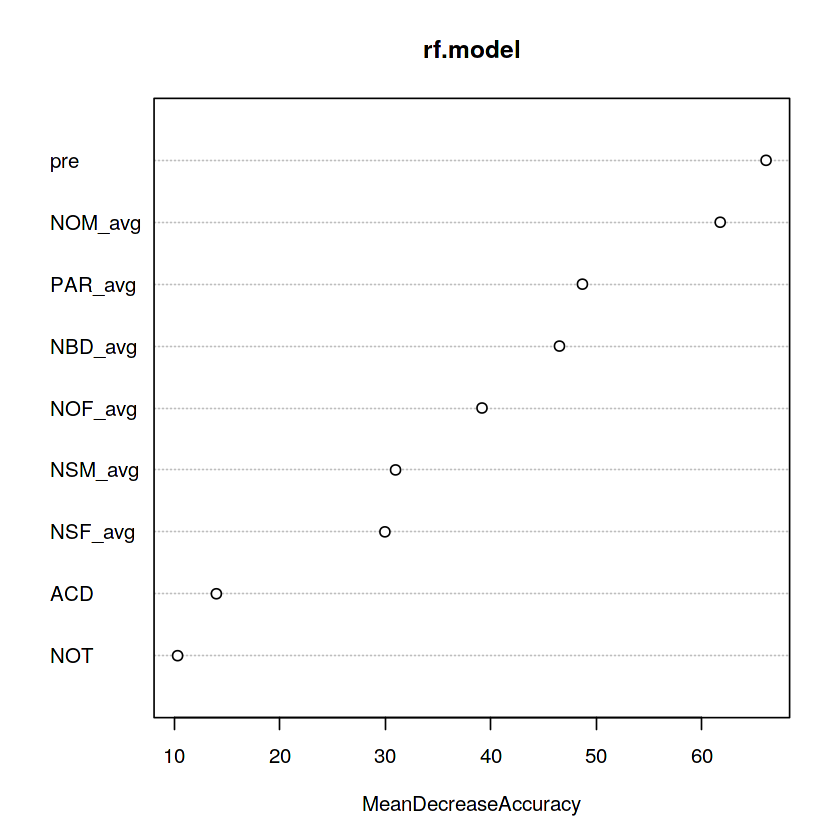

In [85]:
varImpPlot(rf.model, type="1")

## FAST-AND-FRUGAL TREE MODEL

In [86]:
f <- as.formula(paste( "post", '~', paste(indep, collapse = "+")))
fft.model <- FFTrees(formula = f, data = data)
print(fft.model)

post is now logical.


FFT 1 (of 7) predicts post using 3 cues: {pre, NBD_avg, NOM_avg}

[1] If pre <= 0, decide False.
[2] If NBD_avg > 1.3, decide True.
[3] If NOM_avg <= 7.4, decide False, otherwise, decide True.

                     train test
cases       .n    6729.000   --
hits        .hi    636.000   --
misses      .mi    339.000   --
false al    .fa   1368.000   --
corr rej    .cr   4386.000   --
speed       .mcu     1.532   --
frugality   .pci     0.847   --
cost        .cost    0.254   --
accuracy    .acc     0.746   --
balanced    .bacc    0.707   --
sensitivity .sens    0.652   --
specificity .spec    0.762   --

pars: algorithm = 'ifan', goal = 'wacc', goal.chase = 'wacc', sens.w = 0.5, max.levels = 4

## Visualize a FAST-AND-FRUGAL TREE MODEL

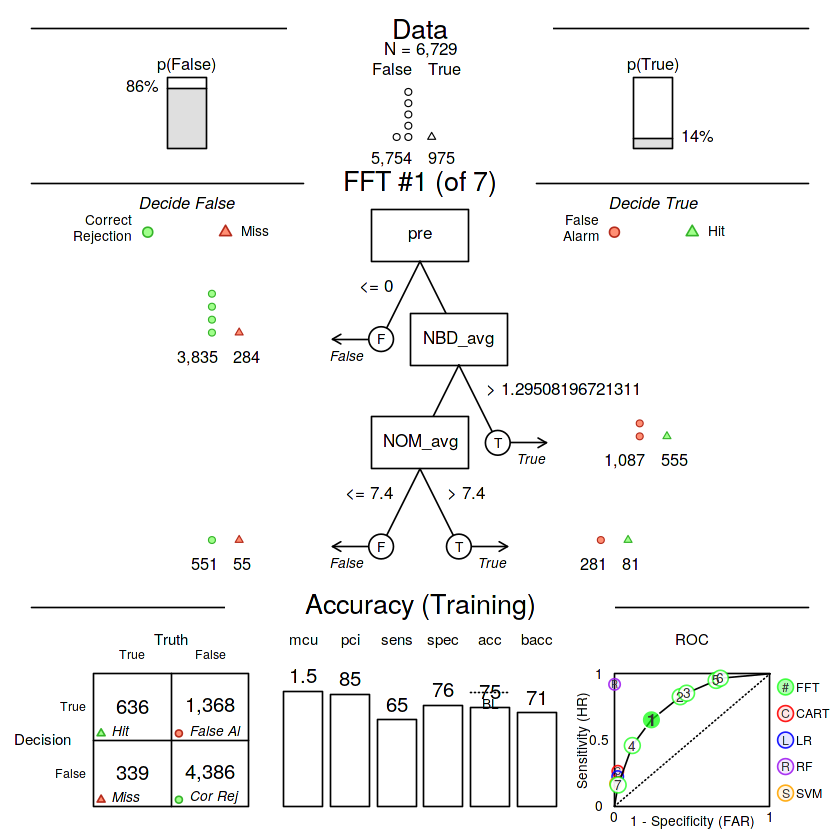

In [87]:
plot(fft.model)

# STEP4: Explore different parameter settings

In [88]:
# results <- list()
# for(i in seq(1,10)){
#   set.seed(i)
#   indices <- sample(nrow(data), replace=TRUE)
#   training <- data[indices,]
#   testing <- data[-indices,]
#   indep <- AutoSpearman(training, eclipse$indep)
#   f <- as.formula(paste( "post", '~', paste(indep, collapse = "+")))
#   
#   glm.model <- glm(f, data = training, family="binomial")
#   defaulttree.model <- C5.0(x = training[, indep], y = training[,dep], rules=TRUE, trials=1)
#   optimaltree.model <- C5.0(x = training[, indep], y = training[,dep], rules=TRUE, trials=100)
#   rf10trees.model <- randomForest(f, data = training, importance = TRUE, ntree=10)
#   rf100trees.model <- randomForest(f, data = training, importance = TRUE, ntree=100)
# 
#   predictions <- data.frame(
#     GLM = predict(glm.model, testing, type="response"),
#     C50.1trial = predict(defaulttree.model, testing, type="prob")[,"TRUE"],
#     C50.100trials = predict(optimaltree.model, testing, type="prob")[,"TRUE"],
#     RF.10trees = predict(rf10trees.model, testing, type="prob")[,"TRUE"],
#     RF.100trees = predict(rf100trees.model, testing, type="prob")[,"TRUE"]
#   )
#   performance <- apply(predictions, 2, function(x) performance.calculation(testing[,dep], x))
#   results[["AUC"]] <- rbind(results[["AUC"]], performance["AUC",])
#   results[["Fmeasure(0.5)"]] <- rbind(results[["Fmeasure(0.5)"]], performance["Fmeasure",])
#   
#   performance <- apply(predictions, 2, function(x) performance.calculation(testing[,dep], x, threshold = 0.2))
#   results[["Fmeasure(0.2)"]] <- rbind(results[["Fmeasure(0.2)"]], performance["Fmeasure",])
#   
#   performance <- apply(predictions, 2, function(x) performance.calculation(testing[,dep], x, threshold = 0.8))
#   results[["Fmeasure(0.8)"]] <- rbind(results[["Fmeasure(0.8)"]], performance["Fmeasure",])
# }
# saveRDS(results, "figures/parameter-settings.rds")

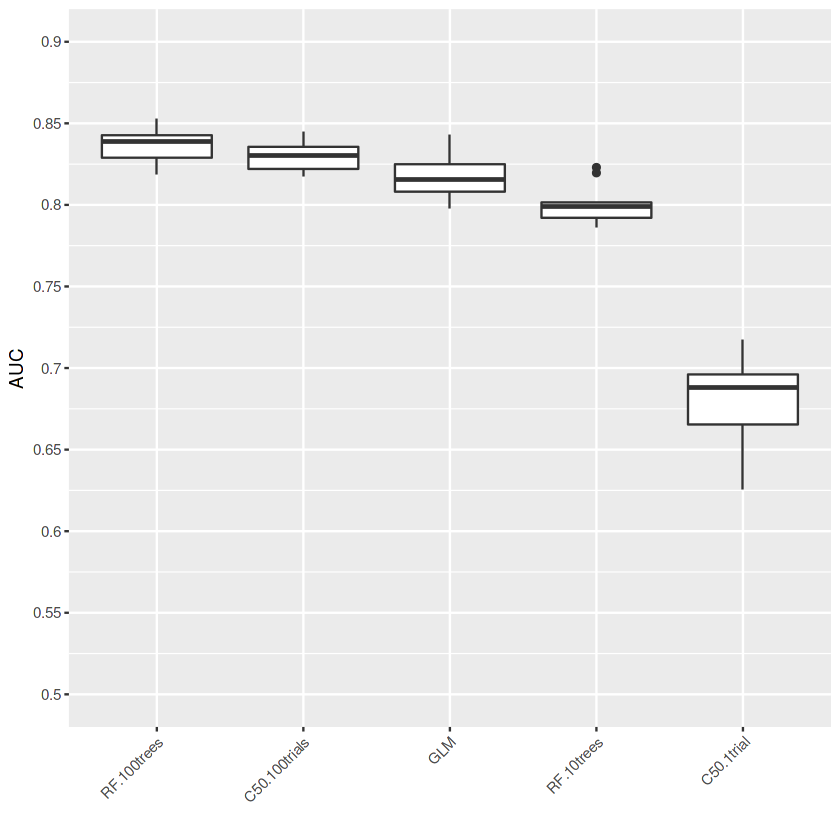

In [89]:
results <- readRDS("figures/parameter-settings.rds")
ggplot(melt(results[["AUC"]]), aes(x=reorder(Var2, -value, median), y=value)) + geom_boxplot()  + ylab("AUC") + xlab("") + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + scale_y_continuous(breaks = 10:18*0.05, labels = 10:18*0.05, limit=c(0.5,0.9))

# STEP5: USE OUT-OF-SAMPLE BOOTSTRAP

Using method as id variables


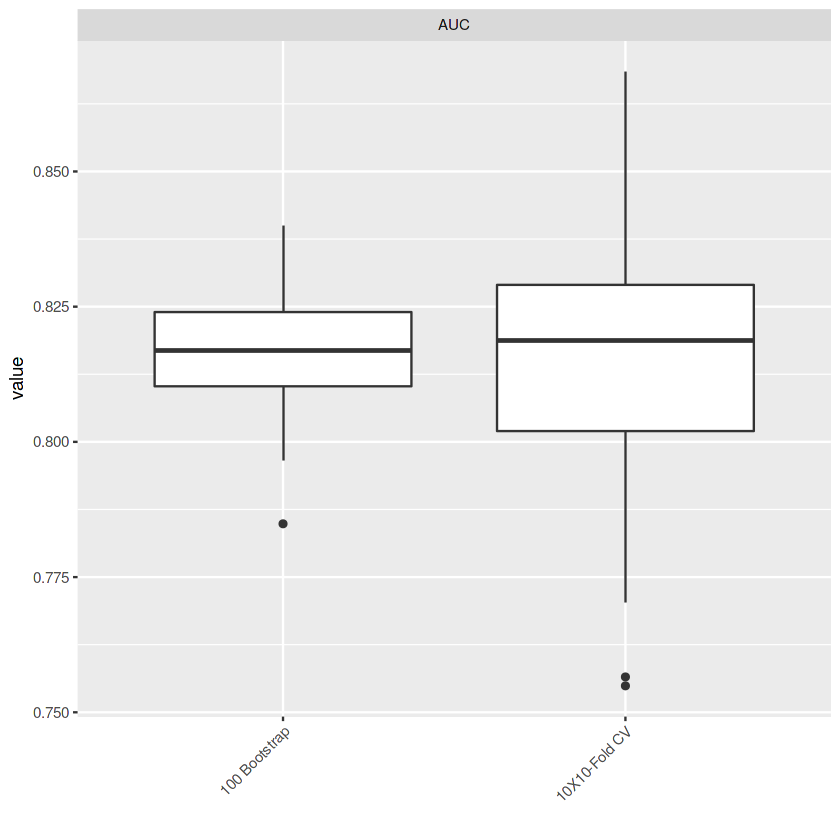

In [90]:
results <- NULL
indep <- AutoSpearman(data, eclipse$indep)
f <- as.formula(paste( "post", '~', paste(indep, collapse = "+")))

for(i in seq(1,100)){
  set.seed(1234+i)
  indices <- sample(nrow(data), replace=TRUE)
  training <- data[indices,]
  testing <- data[-indices,]
  
  m <- glm(f, data = training, family="binomial")
  predictions <- predict(m, testing, type="response")
  performance <- performance.calculation(testing[,dep], predictions)
  results <- rbind(results, c(method="100 Bootstrap",performance["AUC"]))
}

# 10x10-folds CV
for(i in seq(1,10)){
  set.seed(1234+i)
  indices <- createFolds(data[, dep], k = 10, list = TRUE, returnTrain = TRUE)
  for(i in seq(1,10)){
    training <- data[indices[[i]],]
    testing <- data[-indices[[i]],]
    
    m <- glm(f, data = training, family="binomial")
    predictions <- predict(m, testing, type="response")
    performance <- performance.calculation(testing[,dep], predictions)
    results <- rbind(results, c(method="10X10-Fold CV",performance["AUC"]))
  }
}

results <- data.frame(results)
results$AUC <- as.numeric(as.character(results$AUC))

ggplot(melt(results), aes(x=method, y=value)) + geom_boxplot() + ylab("value") + xlab("") + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + facet_wrap(~variable, scales="free_y") 

# STEP6: SUMMARIZE BY A ScottKnott-ESD TEST 

No id variables; using all as measure variables


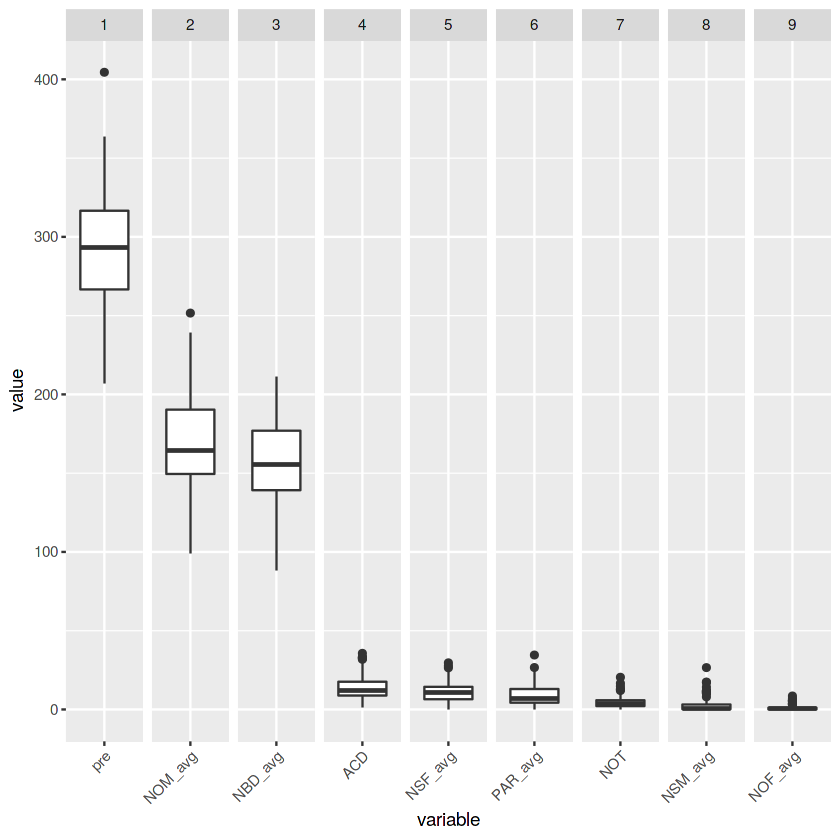

In [91]:
importance <- NULL
indep <- AutoSpearman(data, eclipse$indep)
f <- as.formula(paste( "post", '~', paste(indep, collapse = "+")))
for(i in seq(1,100)){
  indices <- sample(nrow(data), replace=TRUE)
  training <- data[indices,]
  m <- glm(f, data = training, family="binomial")
  importance <- rbind(importance, Anova(m,type="2",test="LR")$"LR Chisq")
}

importance <- data.frame(importance)
colnames(importance) <- indep

df <- melt(importance)
df$rank <- sk_esd(importance)$groups[as.character(df$variable)]

ggplot(df, aes(x=variable, y=value)) + geom_boxplot() + facet_grid(~rank, scales = "free", drop = TRUE) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

# STEP7: VISUALIZE THE RELATIONSHIPS

In [92]:
indep <- AutoSpearman(data, eclipse$indep)
f <- as.formula(paste( "post", '~', paste(indep, collapse = "+")))
m <- glm(f, data = data, family="binomial")

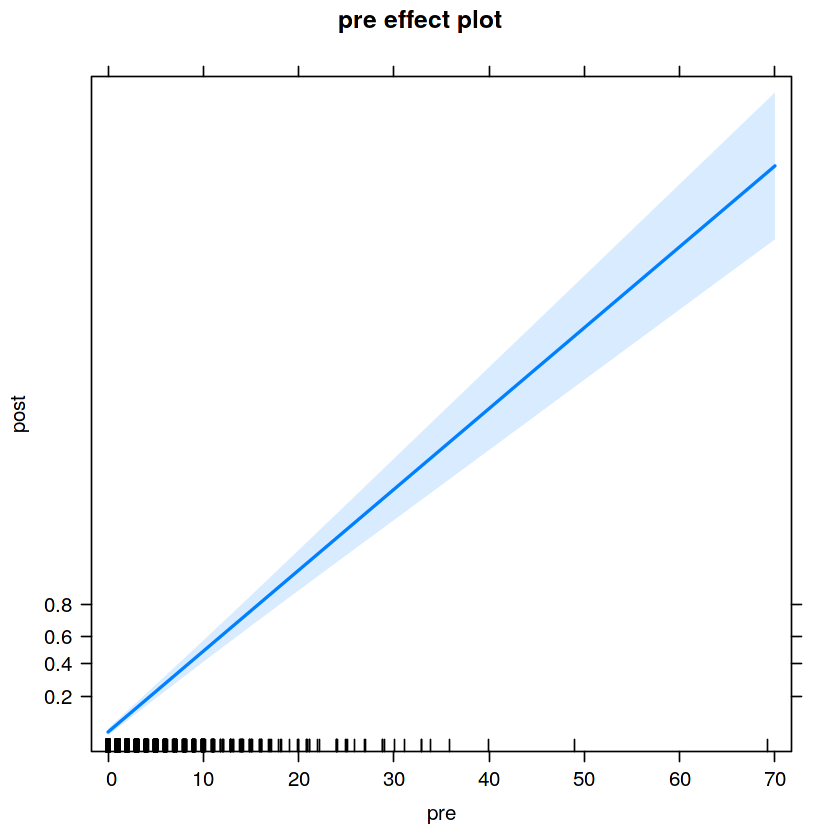

In [93]:
plot(effect("pre",m))

# DON'T USE ANOVA TYPE-I

In [94]:
indep1 <- c("TLOC","NSF_max","NSM_max","NOF_max")
f <- as.formula(paste0(dep, " ~ ", paste0(indep1,collapse = "+")))
m <- glm(f, data=data, family="binomial")
anova(m)

,Df,Deviance,Resid. Df,Resid. Dev
,<int>,<dbl>,<int>,<dbl>
NULL,NA,NA,6728,5568.263
TLOC,1,709.1933977,6727,4859.070
NSF_max,1,0.5941960,6726,4858.476
NSM_max,1,0.1685477,6725,4858.307
NOF_max,1,33.2212919,6724,4825.086


In [95]:
Anova(m)

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
TLOC,630.30444430,1,4.291484e-139
NSF_max,0.09637628,1,7.562224e-01
NSM_max,0.09127543,1,7.625619e-01
NOF_max,33.22129193,1,8.224503e-09


# The risks of reordering model specification

In [96]:

indep1 <- c("NSF_max","NSM_max","NOF_max","ACD")
f <- as.formula(paste0(dep, " ~ ", paste0(indep1,collapse = "+")))
m <- glm(f, data=data, family="binomial")

importance1 <- data.frame(Type1.1=anova(m)$Deviance[-1], Type2.1=Anova(m,type="2",test="LR")$"LR Chisq")
rownames(importance1) <- indep1

indep2 <- c("NSM_max","ACD","NSF_max","NOF_max")
f <- as.formula(paste0(dep, " ~ ", paste0(indep2,collapse = "+")))
m <- glm(f, data=data, family="binomial")
importance2 <- data.frame(Type1.2=anova(m)$Deviance[-1], Type2.2=Anova(m,type="2",test="LR")$"LR Chisq")
rownames(importance2) <- indep2

importance <- data.frame(importance1[indep1,],importance2[indep1,])
importance <- data.frame(apply(importance, 2, function(x){x/sum(abs(x))}))

round(importance[order(-importance$Type2.1),], digit=2)*100

,Type1.1,Type2.1,Type1.2,Type2.2
,<dbl>,<dbl>,<dbl>,<dbl>
ACD,28,47,49,47
NOF_max,32,23,13,23
NSM_max,11,19,31,19
NSF_max,29,11,7,11


# DON’T CHANGE PROBABILITY THRESHOLD

No id variables; using all as measure variables
No id variables; using all as measure variables
No id variables; using all as measure variables


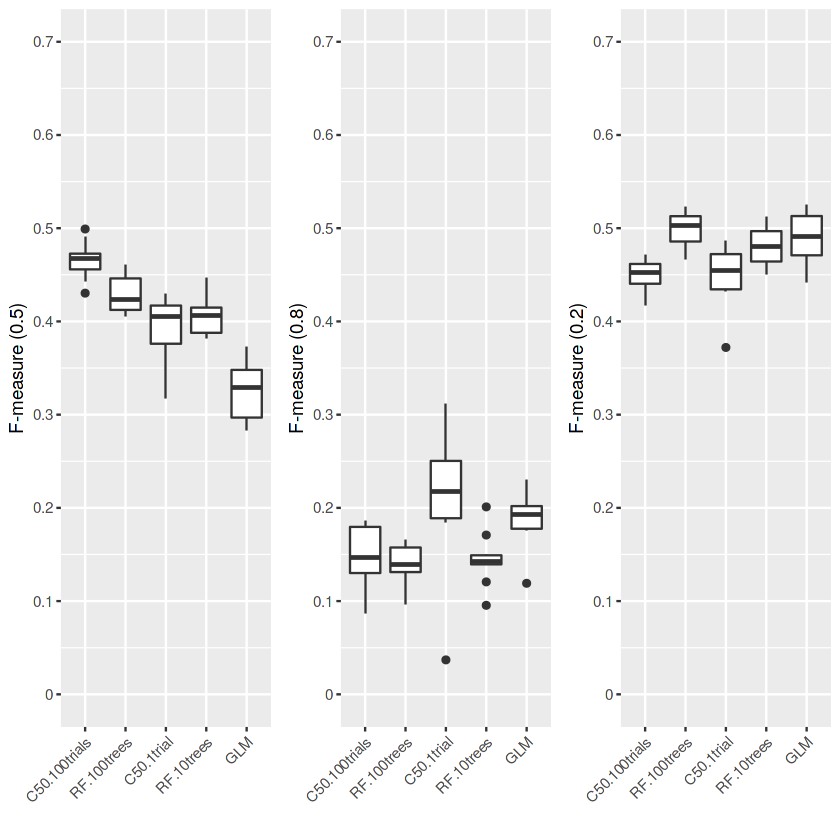

In [97]:
results <- readRDS("figures/parameter-settings.rds")
levels <- c("C50.100trials","RF.100trees","C50.1trial","RF.10trees","GLM")
g1<- ggplot(melt(data.frame(results[["Fmeasure(0.5)"]])), aes(x=factor(variable, levels=levels), y=value)) + geom_boxplot()  + ylab("F-measure (0.5)") + xlab("") + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + scale_y_continuous(labels=0:7*0.1, breaks=0:7*0.1, limit=c(0, 0.7))

g2<- ggplot(melt(data.frame(results[["Fmeasure(0.8)"]]),na.rm=TRUE), aes(x=factor(variable, levels=levels), y=value)) + geom_boxplot() + ylab("F-measure (0.8)") + xlab("") + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + scale_y_continuous(labels=0:7*0.1, breaks=0:7*0.1, limit=c(0, 0.7))

g3<- ggplot(melt(data.frame(results[["Fmeasure(0.2)"]]),na.rm=TRUE), aes(x=factor(variable, levels=levels), y=value)) + geom_boxplot()  + ylab("F-measure (0.2)") + xlab("") + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + scale_y_continuous(labels=0:7*0.1, breaks=0:7*0.1, limit=c(0, 0.7))

grid.arrange(g1,g2,g3,ncol=3)

# DON’T REBALANCE THE DATA

No id variables; using all as measure variables
No id variables; using all as measure variables


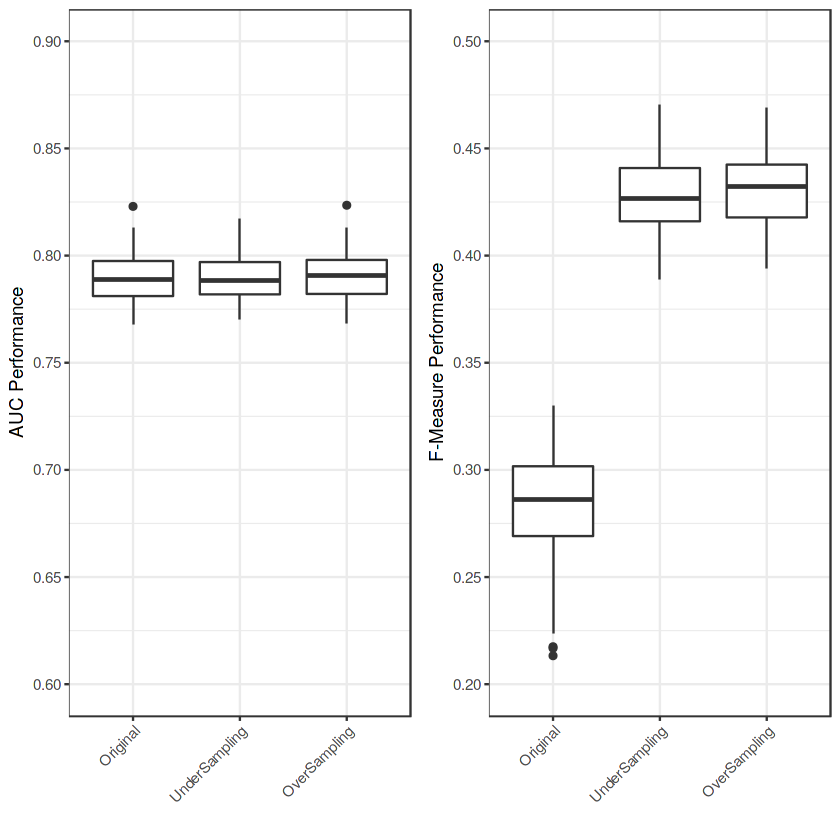

In [98]:

indep <- c("TLOC","PAR_max",'NOI',"NOF_max","FOUT_max","NSM_max","NSF_max","ACD","NOM_max")

original.m <- fit(data, dep, indep, classifier="lr", rebalance="no", validation="boot")
down.m <- fit(data, dep, indep, classifier="lr", rebalance="down", validation="boot")
up.m <- fit(data, dep, indep, classifier="lr", rebalance="up", validation="boot")

auc <- data.frame(Original=original.m$performance$AUC, 
                  UnderSampling=down.m$performance$AUC,
                  OverSampling=up.m$performance$AUC)
g1 <- ggplot(melt(auc), aes(x=variable, y=value)) + geom_boxplot() + theme_bw() + ylab("AUC Performance") + xlab("") + scale_y_continuous(breaks=12:20*0.05, limits = c(0.6,0.9)) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

fmeasure <- data.frame(Original=original.m$performance$Fmeasure, 
                       UnderSampling=down.m$performance$Fmeasure,
                       OverSampling=up.m$performance$Fmeasure)
g2 <- ggplot(melt(fmeasure), aes(x=variable, y=value)) + geom_boxplot() + theme_bw() + ylab("F-Measure Performance") + xlab("") + scale_y_continuous(breaks=4:10*0.05, limits = c(0.2,0.5)) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

grid.arrange(g1,g2, ncol=2)